# Demand Forecast

This notebook focuses on the forecast of demand once data cleaning has been completed. 
The objective is to forecast the Order_Demand column. the timeframe has not been defined in the exrcise, so we will assume we need a 3 months forecast. We will start trying to forecast the total sum of demand and, when happy when the model, forecast at warehouse level. Forecast at lower level is not covered in this exercise. Due to time contraints, the forecast for out of sample data has not been performed.

After preliminar EDA in PBI with clean data it is clear that there is weekly seasonality in the demand. Less significant, we should also consider the impact of monthly seasonality and holidays. For these reasons, SARIMAX model has been selected to model the forecast: allows modelling seasonal data and including exogenous variables.

Steps:
 
1. Load clean data and generate exogenous data. Calculate total demand.
2. Split into train and test datasets
3. Stationarity. ACF and PACF plots
4. Decompose time series and plot residuals. 
5. Fit model and predict for test data.
6. Calculate warehouse totals
7. Fit model to warehouse data and predict test data
8. Forecast for next 3 months (TBD)





In [3]:
# Import dependencies

import pandas as pd
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt
%matplotlib inline


## Load clean data and create exogenous dataset

In [4]:
# read clean dataframe with all time series
df = pd.read_pickle('df_clean.pkl')
df.index.freq = 'd'
df.describe()

,"(Product_0001, Whse_A, Category_005)","(Product_0001, Whse_J, Category_005)","(Product_0002, Whse_C, Category_005)","(Product_0002, Whse_S, Category_005)","(Product_0003, Whse_J, Category_005)","(Product_0003, Whse_S, Category_005)","(Product_0004, Whse_J, Category_005)","(Product_0005, Whse_J, Category_005)","(Product_0006, Whse_J, Category_005)","(Product_0007, Whse_J, Category_005)",...,"(Product_2168, Whse_A, Category_024)","(Product_2168, Whse_J, Category_024)","(Product_2168, Whse_S, Category_024)","(Product_2169, Whse_A, Category_024)","(Product_2169, Whse_C, Category_024)","(Product_2169, Whse_J, Category_024)","(Product_2169, Whse_S, Category_024)","(Product_2170, Whse_C, Category_024)","(Product_2171, Whse_J, Category_007)","(Product_2172, Whse_J, Category_005)"
count,1827.000000,1827.000000,1827.000000,1827.000000,1827.000000,1827.000000,1827.000000,1827.000000,1827.000000,1827.000000,...,1827.000000,1827.000000,1827.000000,1827.000000,1827.000000,1827.000000,1827.000000,1827.000000,1827.000000,1827.000000
mean,166.748768,51.368363,85.249042,3388.770297,45.835614,9.624156,55.587484,9.706258,3.831418,87.301587,...,1.273946,12.732120,6.169905,0.451286,4.694946,2.189199,3.680806,0.826856,0.928754,8.894362
std,633.715243,151.510429,499.471222,13314.060583,172.634215,87.251613,264.994503,77.540883,31.554991,227.764823,...,5.388730,55.483974,31.169183,2.178088,23.653101,12.830838,23.337313,3.563499,2.672847,67.917572
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000
max,7000.000000,2300.000000,7000.000000,251500.000000,3000.000000,2500.000000,8000.000000,1200.000000,500.000000,2000.000000,...,80.000000,500.000000,400.000000,40.000000,325.000000,200.000000,400.000000,63.000000,38.500000,1000.000000


In [5]:
print('min date ' + str(df.index.min()))
print('max date ' + str(df.index.max()))

min date 2012-01-01 00:00:00
max date 2016-12-31 00:00:00


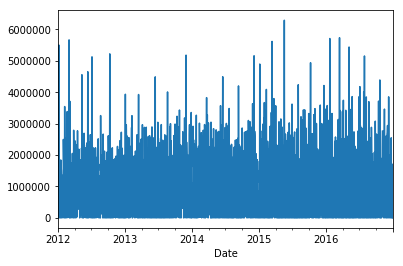

In [6]:
# lets focus on predicting the total sum
df_total = df.sum(axis=1)

df_total.plot()


In [7]:
# load list of holidays
list_holidays = pd.read_csv('holidays.csv', header=None).iloc[:, 0].to_list()

# create some exogenous data using calendar properties

df_exog = pd.DataFrame(pd.period_range(df_total.index.min(), df_total.index.max(), freq='D'), columns=['Date'])
df_exog = df_exog.set_index(df_exog['Date'])
df_exog['weekday'] = df_exog.index.weekday
df_exog['month'] = df_exog.index.month
df_exog['day'] = df_exog.index.day
df_exog['holidays'] = 0 
df_exog.loc[df_exog.index.astype(str).isin(list_holidays), 'holidays'] = 1

df_exog['holidays_lead'] = df_exog['holidays'].shift(-1).fillna(0)
df_exog['holidays_lag'] = df_exog['holidays'].shift(1).fillna(0)

#df_exog.index.freq = 'd'
# Add flag for weekend or public holiday
df_exog['holidays_or_weekend'] = df_exog['holidays'] 
df_exog.loc[df_exog['weekday'].isin([5,6]), 'holidays_or_weekend'] = 1

df_exog = df_exog.drop(columns=['Date'])


# Add dummy columns for month and weekday
df_exog = pd.concat([df_exog.drop(columns=['month']), pd.get_dummies(df_exog['month'], drop_first=True, prefix='Month')], axis=1)
df_exog = pd.concat([df_exog.drop(columns=['weekday']), pd.get_dummies(df_exog['weekday'], drop_first=True, prefix='Weekday')], axis=1)



## Split into Train and test sets

On order to develop and tune the forecasting model we need to split our dataset into train and test sets. We will use 2016 as test set. 

In [8]:
df_train = df_total.loc[df.index < '2016-07-01']
df_test = df_total.loc[df.index >= '2016-07-01']

df_exog_train = df_exog.loc[df.index < '2016-07-01']
df_exog_test = df_exog.loc[df.index >= '2016-07-01']


In [9]:
# Check Stationarity in train data

#ADF-test(Original-time-series)
res = sm.tsa.adfuller(df_train.dropna(),regression='ct')
print('p-value:{}'.format(res[1]))

p-value:7.005161371528653e-14


p-value << 0.05 so the series is already stationary and we would not need to differenciate the time series to fit any model. 

## Check Autocorrelation and partial autocorrelation

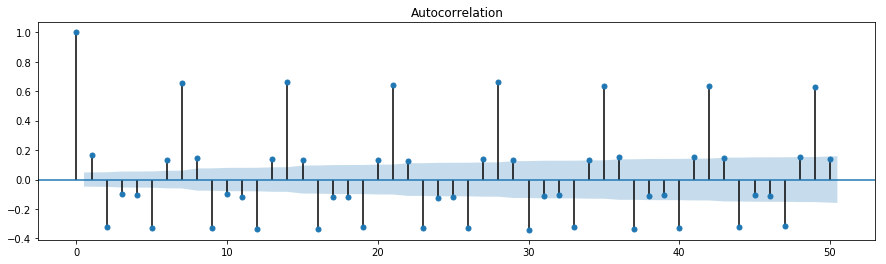

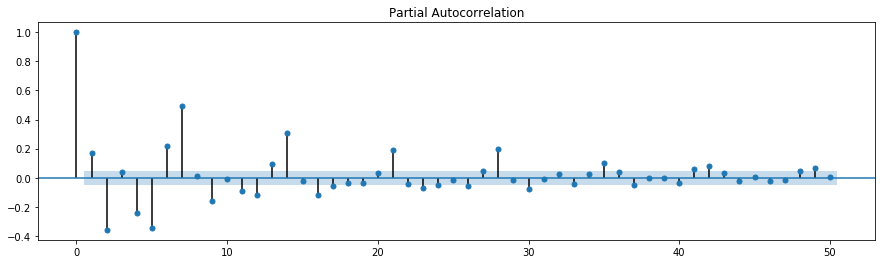

In [10]:
fig = sm.graphics.tsa.plot_acf(df_train.dropna().values.squeeze(), lags=50)
fig.set_figwidth(15)
plt.show()

fig = sm.graphics.tsa.plot_pacf(df_train.dropna(), lags=50)
fig.set_figwidth(15)
plt.show()


As expected, there is a weekly seasonality in APF, but we find it as well in PAFC. The (p, q) parameters in the SARIMAX model should be (7, 7), respectively. Anyway, we can run an additional check with a built-in method in statsmodels.

In [11]:
import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)


resDiff = sm.tsa.arma_order_select_ic(df_train.dropna(), max_ar=7, max_ma=7, ic='aic', trend='c')
print('ARMA(p,q) =', resDiff['aic_min_order'],' is the best.')

C:\Users\W100372\AppData\Roaming\Python\Python36\site-packages\statsmodels\base\model.py:548: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users\W100372\AppData\Roaming\Python\Python36\site-packages\statsmodels\base\model.py:548: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users\W100372\AppData\Roaming\Python\Python36\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
C:\Users\W100372\AppData\Roaming\Python\Python36\site-packages\statsmodels\base\model.py:548: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users\W100372\AppData\Roaming\Python\Python36\site-packages\statsmodels\base\model.py:548: HessianInversionWarning: Inverting hessian failed, n

## Seasonal decomposition

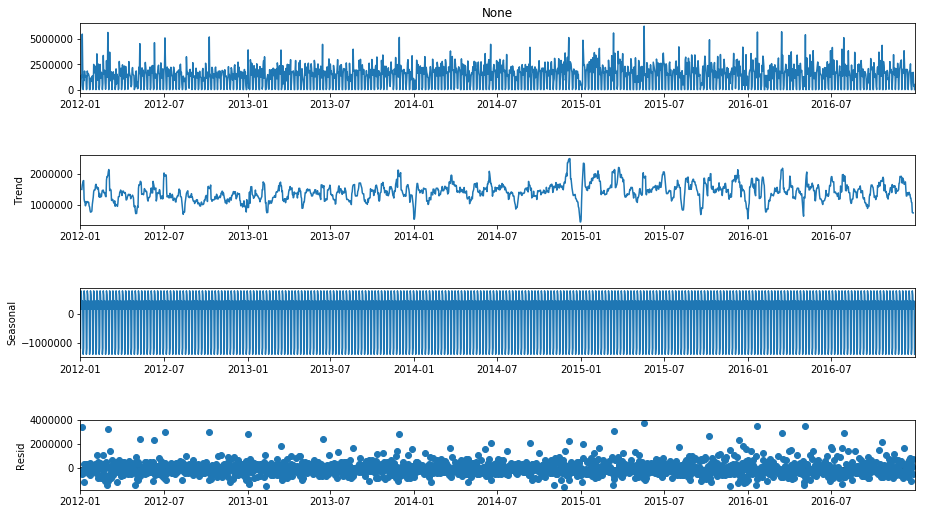

In [13]:
# seasonal decomposition. let's use 7 days seasonality as found before and in PBI. 
res = sm.tsa.seasonal_decompose(df_total, period=7)

fig = res.plot()
fig.set_figheight(8)
fig.set_figwidth(15)
plt.show()


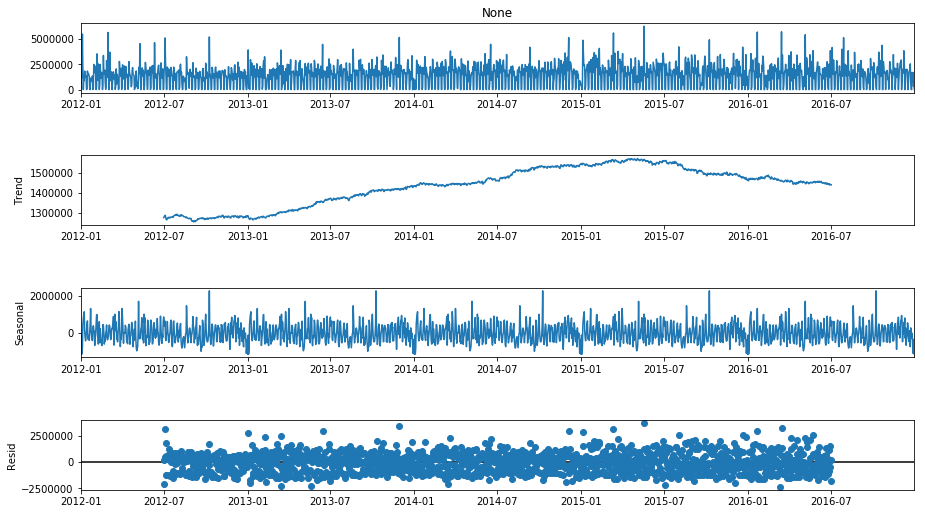

In [12]:
# Let's check as well yearly seasonality 
res = sm.tsa.seasonal_decompose(df_total, period=365)

fig = res.plot()
fig.set_figheight(8)
fig.set_figwidth(15)
plt.show()

We can find a long term trend. However, in practise we can't use 365 as parameter in our model since it is too large. In this exercise this will be disregarded.

## Model fit and prediction

In [14]:
model = sm.tsa.statespace.SARIMAX(df_train.values, order=(7,0,7)
                                  , seasonal_order=(0,0,0,7)
                                  , exog = df_exog_train.values.astype('float64'))
model_fit = model.fit(maxiter=50)
model_fit.summary()


C:\Users\W100372\AppData\Roaming\Python\Python36\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                 1643
Model:               SARIMAX(7, 0, 7)   Log Likelihood              -24466.105
Date:                Tue, 23 Feb 2021   AIC                          49006.211
Time:                        10:15:40   BIC                          49206.169
Sample:                             0   HQIC                         49080.363
                               - 1643                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
x1          1.898e+04   2011.910      9.433      0.000     1.5e+04    2.29e+04
x2          1.054e+04      2.179   4837.769      0.000    1.05e+04    1.05e+04
x3         -2.835e+05      3.542     -8e+04      0.000   -2.84e+05   -2.84e+05
x4          2.058e+05     11.429    1.8e+04      0.000    2.06e+05    2.06e+05
x5           2.67e+04      2.660      1e+04      0.000    2.67e+04    2.67e+04
x6          1.222e+06      1.564   7.81e+05      0.000    1.22e+06    1.22e+06
x7          1.367e+06      3.143   4.35e+05      0.000    1.37e+06    1.37e+06
x8          1.234e+06      2.671   4.62e+05      0.000    1.23e+06    1.23e+06
x9          1.196e+06      1.395   8.57e+05      0.000     1.2e+06     1.2e+06
x10         1.304e+06      0.312   4.17e+06      0.000     1.3e+06     1.3e+06
x11         1.238e+06        nan        nan        nan         nan         nan
x12         1.127e+06      1.156   9.75e+05      0.000    1.13e+06    1.13e+06
x13          1.16e+06      1.162   9.98e+05      0.000    1.16e+06    1.16e+06
x14         1.259e+06      0.977   1.29e+06      0.000    1.26e+06    1.26e+06
x15         1.302e+06        nan        nan        nan         nan         nan
x16         1.236e+06      8.571   1.44e+05      0.000    1.24e+06    1.24e+06
x17         6.942e+05      5.337    1.3e+05      0.000    6.94e+05    6.94e+05
x18         1.735e+05      5.149   3.37e+04      0.000    1.74e+05    1.74e+05
x19         4.813e+05      0.867   5.55e+05      0.000    4.81e+05    4.81e+05
x20         4.235e+05      1.942   2.18e+05      0.000    4.24e+05    4.24e+05
x21        -1.433e+06      0.067  -2.15e+07      0.000   -1.43e+06   -1.43e+06
x22        -1.211e+06      1.206     -1e+06      0.000   -1.21e+06   -1.21e+06
ar.L1          0.2550      0.106      2.414      0.016       0.048       0.462
ar.L2         -0.2316      0.113     -2.050      0.040      -0.453      -0.010
ar.L3          0.1335      0.122      1.090      0.276      -0.106       0.373
ar.L4         -0.0179      0.125     -0.143      0.886      -0.263       0.227
ar.L5         -0.1021      0.120     -0.849      0.396      -0.338       0.133
ar.L6          0.1886      0.109      1.738      0.082      -0.024       0.401
ar.L7          0.7183      0.101      7.098      0.000       0.520       0.917
ma.L1         -0.1164      0.117     -0.995      0.320      -0.346       0.113
ma.L2          0.4300      0.112      3.852      0.000       0.211       0.649
ma.L3          0.0128      0.134      0.095      0.924      -0.250       0.275
ma.L4          0.1631      0.132      1.233      0.217      -0.096       0.422
ma.L5          0.2685      0.123      2.176      0.030       0.027       0.510
ma.L6         -0.0785      0.115     -0.684      0.494      -0.303       0.146
ma.L7         -0.4784      0.096     -4.972      0.000      -0.667      -0.290
sigma2      4.967e+11      0.000   4.62e+15      0.000    4.97e+11    4.97e+11
=================================================================================

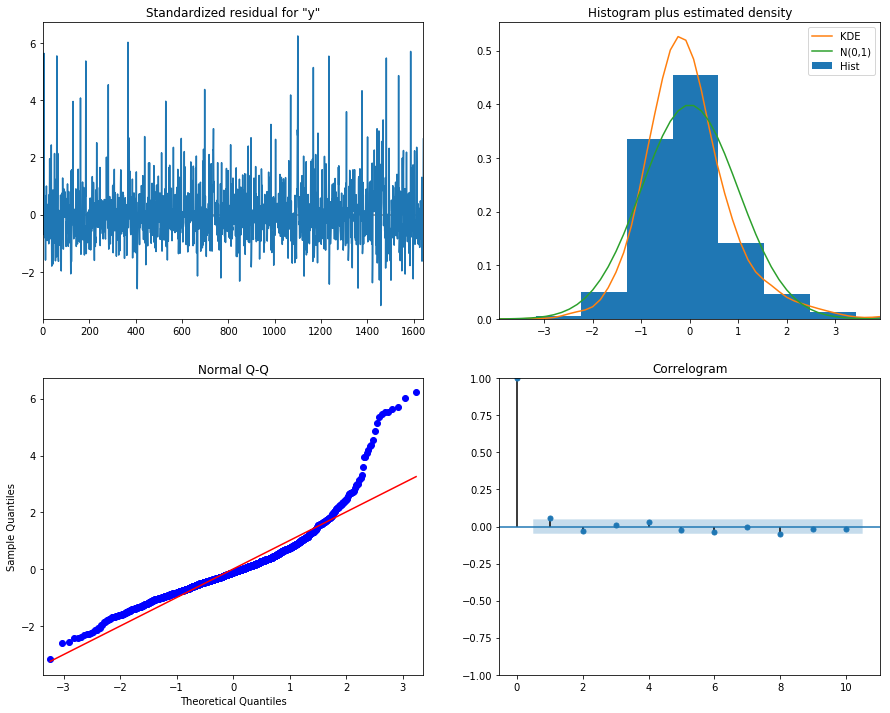

In [15]:

fig = model_fit.plot_diagnostics(figsize=(15, 12))


There is still some skewness in the residuals distribution, due to outliers. One possible explanation for them is that data from previous days to an outlier was not  reported, i.e. data from holidays or weekends reported in next working day, leading to a peak.
On the other side there is a negligible autocorrelation in the residuals, so in principle we have captured all the short term seasonality in the data.

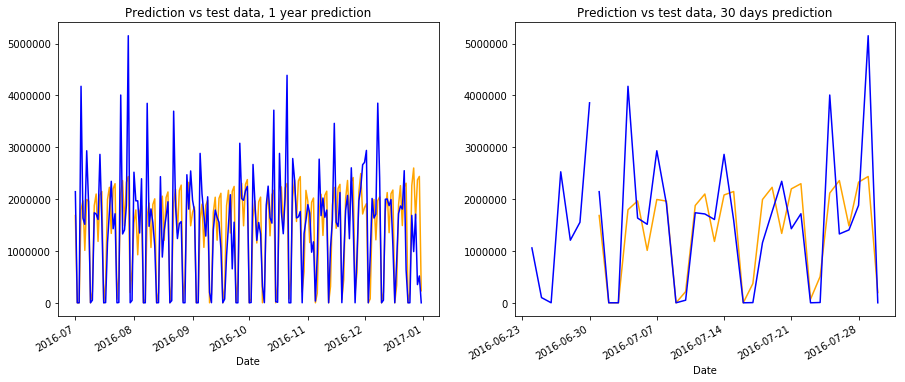

In [16]:
# Make prediction for test data, 

pred = model_fit.predict(len(df_train), len(df_train) + len(df_test) - 1, exog=df_exog_test)

# correct negative values to 0
pred[pred < 0] = 0

fig, ax = plt.subplots(1, 2, figsize=(15, 6))

# let's plot comparison of daily data, predictions Vs test
ax[0].plot(df_test.index, pred, color='orange')
df_test.plot(ax=ax[0], color='blue')
ax[0].set_title('Prediction vs test data, 1 year prediction')

# let's plot the first month
ax[1].plot(df_test.iloc[:30].index, pred[:30], color='orange')
df_test.iloc[:30].plot(ax=ax[1], color='blue')
ax[1].set_title('Prediction vs test data, 30 days prediction')
df_train.iloc[-7:].plot(ax=ax[1], color='blue')

In [17]:
# Due to the high number of 0 in the test target we can't use MAPE for checking the accuracy of each prediction, but we calculate the relative error in the prediction of the total sum for the test period. For checking the accuracy of the predictions we will use R2 instead.


from sklearn.metrics import r2_score
print('\nSARIMAX model R2: {:.2f}'.format(r2_score(df_test.values,pred)))

print('\nRelative error in total sum in test period: {:.2%}'.format((np.sum(pred) - df_test.sum()) / df_test.sum()))



SARIMAX model R2: 0.53

Relative error in total sum in test period: -1.30%


Even if the error in the totals is very low, it is a bit misleading, since R2 could be better. Next let's check if we can get a better forecast by forecasting the total for each warehouse.

## Prediction of total demand by predicting demand at warehouse level

In [18]:
df.columns
df_groups = pd.DataFrame(data=df.columns, index=np.arange(len(df.columns)))
df_groups[['Product', 'Whse', 'Category']] = pd.DataFrame(df_groups[0].tolist(), index=df_groups.index)
df_groups = df_groups.drop(columns=[0])

list_whse = df_groups.Whse.unique()

dct_whse = dict()
for w in list_whse:
    dct_whse[w] = dict()
    dct_whse[w]['total'] = df.iloc[:, df_groups.loc[df_groups.Whse == w].index].sum(axis=1)


In [19]:
def split_train_test(df, date):
    train = df.loc[df.index < date]
    test = df.loc[df.index >= date]

    return train, test

start_dt_test = '2016-07-01'

for k, v in dct_whse.items():
    v['train'], v['test'] = split_train_test(v['total'], start_dt_test)


In [20]:
# Let's check stationarity for train demand for each Warehouse
for k, v in dct_whse.items():
    res = sm.tsa.adfuller(v['train'].dropna(),regression='ct')
    print('p-value:{}'.format(res[1]))

p-value:9.824723330836191e-14
p-value:5.132308764551319e-14
p-value:7.364756580750371e-15
p-value:4.692698519359451e-12


All are quite low, so we can continue without differenciating 

In [21]:
# let's check the ACF and PACF plots. If they are similar to the ones for the total, we will apply a SARIMAX model with the same parameters.


Plots for Whse_A


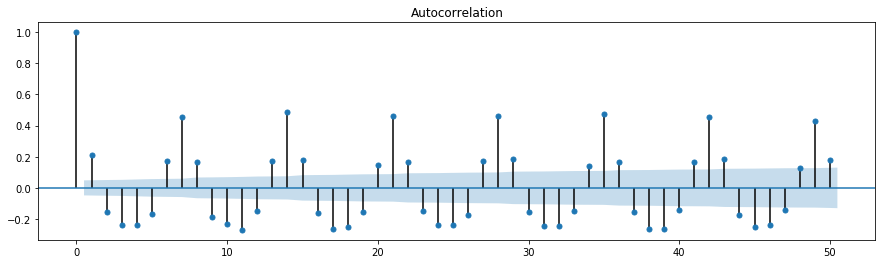

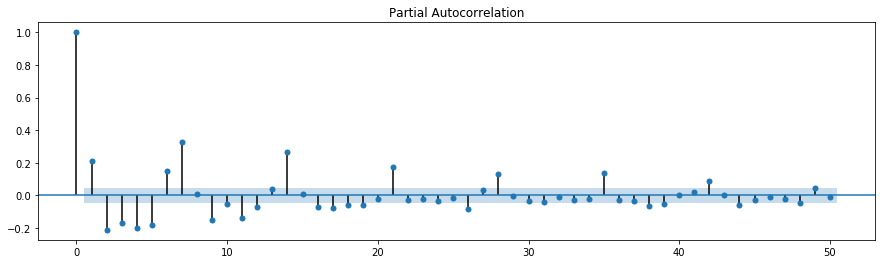


Plots for Whse_J


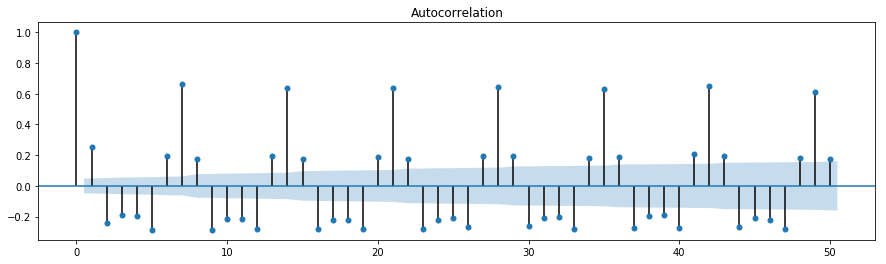

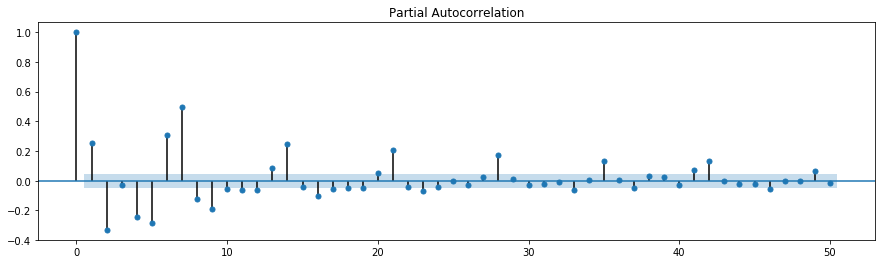


Plots for Whse_C


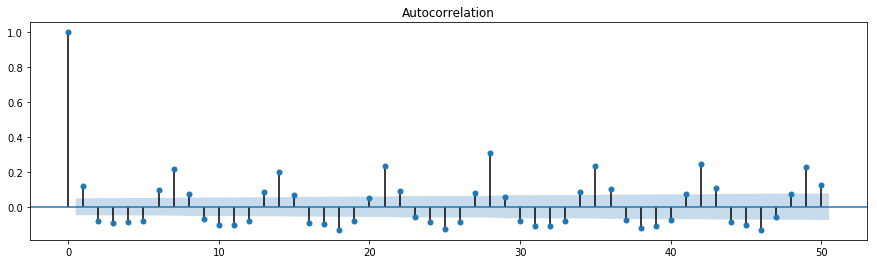

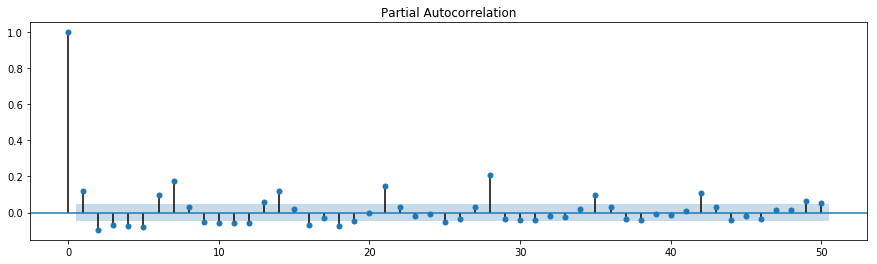


Plots for Whse_S


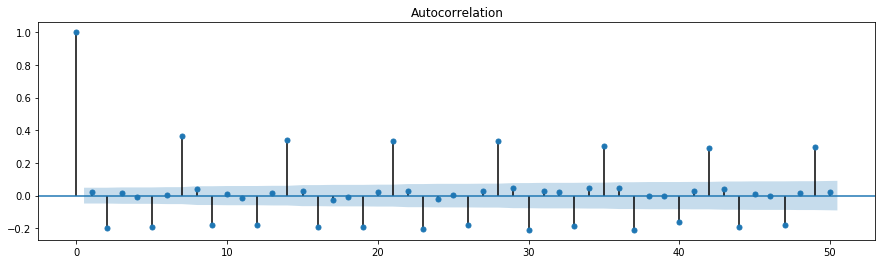

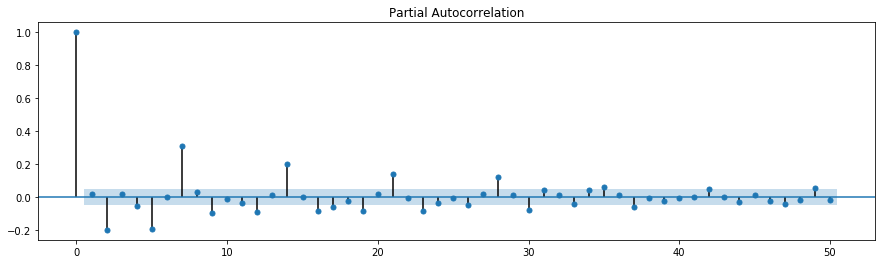

In [22]:
for k, v in dct_whse.items():

    print('\nPlots for ' +  k)

    fig = sm.graphics.tsa.plot_acf(v['train'].dropna(), lags=50)
    fig.set_figwidth(15)
    plt.show()

    fig = sm.graphics.tsa.plot_pacf(v['train'].dropna(), lags=50)
    fig.set_figwidth(15)
    plt.show()

We find the same 7 day period seasonality in all, with small differences in the negative peaks. We will assume the same SARIMAX model is valid in these cases.



In [86]:
for k, v in dct_whse.items():

    print('\nFitting and predicting for ' +  k)

    model = sm.tsa.statespace.SARIMAX(v['train'].values, order=(7,0,7)
                                  , seasonal_order=(0,0,0,7)
                                  , exog = df_exog_train.values.astype('float64')
                                  ,enforce_stationarity=False)
    model_fit = model.fit(maxiter=50)

    pred = model_fit.predict(len(v['train']), len(v['train']) + len(v['test']) - 1
                , exog=df_exog_test
                ,enforce_stationarity=False)
    pred[pred < 0] = 0

    v['pred'] = pred

    print('SARIMAX model R2: {:.2f}'.format(r2_score(v['test'].values, pred)))
    print('Relative error in total sum in test period: {:.2%}'.format((np.sum(pred) - v['test'].sum()) / v['test'].sum()))




Fitting and predicting for Whse_A
C:\Users\W100372\AppData\Roaming\Python\Python36\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
SARIMAX model R2: 0.19
Relative error in total sum in test period: -12.52%

Fitting and predicting for Whse_J
C:\Users\W100372\AppData\Roaming\Python\Python36\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
SARIMAX model R2: 0.59
Relative error in total sum in test period: -11.13%

Fitting and predicting for Whse_C
C:\Users\W100372\AppData\Roaming\Python\Python36\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
SARIMAX model R2: 0.13
Relative error in total sum in test period: -19.09%

Fitting and predicting for Whse_S
C:\Users\W100372\

In [90]:
# Now we will check if the sum of the totals for the warehouse allows to reach a higher R2 for the total demand

pred_at_whse_level = np.zeros(len(df_test))

for k, v in dct_whse.items():
    pred_at_whse_level += v['pred']

print('R2 using Whse predictions: {:.2f}'.format(r2_score(df_test.values, pred_at_whse_level)))
print('Relative error in total sum in test period: {:.2%}'.format((np.sum(pred_at_whse_level) - df_test.sum()) / df_test.sum()))



R2 using Whse predictions: 0.57
Relative error in total sum in test period: -1.67%


We improved slightly the R2 and got a slightly worse result in the sum of demand for the 6 months, but this last was quite good already. This gives some optimism on proceeding like this with lower level data, i.e. Produc_Code level.

## Forecast for next 3 months (out of sample)

TBD